In [1]:
import random

from torchvision import transforms
from torch.utils.data import DataLoader
from Model import FlyingChairsDataset

# root = r"C:\Users\simon\Desktop\RV\Racunalniski Vid\RV-N3\datasets\FlyingChairs_release"
root = r"E:\datasets\FlyingChairs_release"

# transform = transforms.ToTensor()
# transform = None
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="train")
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

imgs, flows = next(iter(loader))
print(imgs.shape, flows.shape)


torch.Size([16, 6, 256, 256]) torch.Size([16, 2, 256, 256])


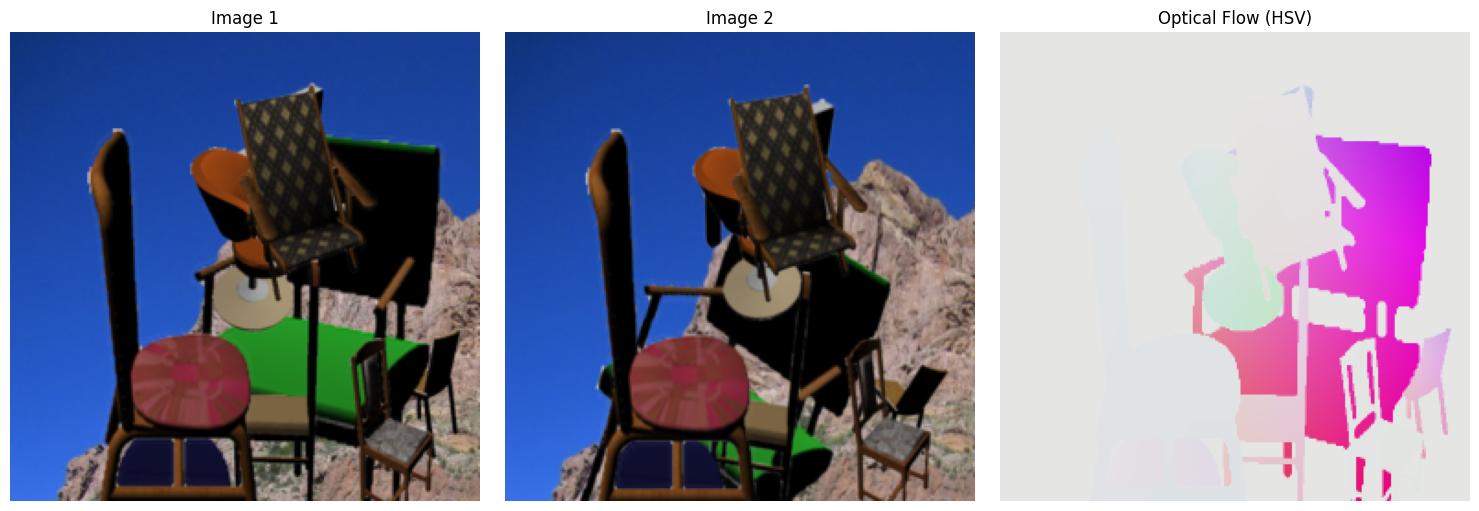

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

imgs, flows = next(iter(loader))

# Extract first sample from batch
img_pair = imgs[0]  # Shape: (6, H, W)
flow = flows[0]     # Shape: (2, H, W)

# Split the 6-channel image into two 3-channel images
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

# Convert flow to numpy (H, W, 2)
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)  # [-pi, pi]

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)  # hue ∈ [0,1]
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)  # saturation ∈ [0,1]
v_ = np.ones_like(s) * 0.9  # brightness

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(img2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Optical Flow (HSV)")
plt.imshow(rgb_flow)
plt.axis("off")

plt.tight_layout()
plt.show()

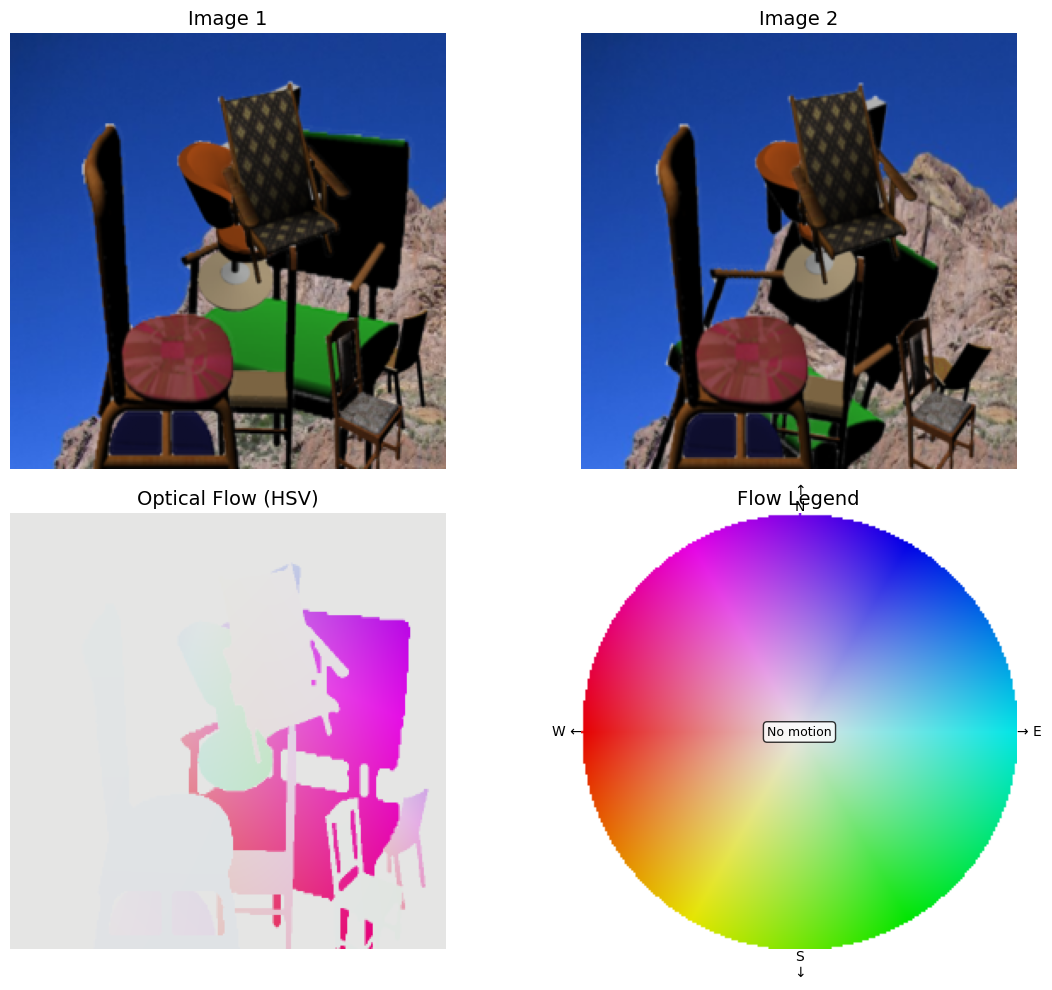

Flow magnitude range: [0.05, 79.58] pixels
Mean flow magnitude: 9.46 pixels


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Extract first sample from batch
img_pair = imgs[0]
flow = flows[0]

# Split images and convert to numpy
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
v_ = np.ones_like(s) * 0.9

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# --- Create colorwheel legend ---
def make_colorwheel(size=256):
    """Create a colorwheel showing flow direction and magnitude"""
    y, x = np.mgrid[-size//2:size//2, -size//2:size//2]

    angle = np.arctan2(-y, x)
    radius = np.sqrt(x**2 + y**2)

    hue = (angle + np.pi) / (2 * np.pi)
    saturation = np.clip(radius / (size // 2), 0, 1)
    value = np.ones_like(saturation) * 0.9

    hsv_wheel = np.stack([hue, saturation, value], axis=-1)
    rgb_wheel = mcolors.hsv_to_rgb(hsv_wheel)

    mask = radius > (size // 2)
    rgb_wheel[mask] = 1

    return rgb_wheel

colorwheel = make_colorwheel(200)

# --- Plot in 2 rows ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First row: images
axes[0, 0].set_title("Image 1", fontsize=14)
axes[0, 0].imshow(img1)
axes[0, 0].axis("off")

axes[0, 1].set_title("Image 2", fontsize=14)
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")

# Second row: flow and legend
axes[1, 0].set_title("Optical Flow (HSV)", fontsize=14)
axes[1, 0].imshow(rgb_flow)
axes[1, 0].axis("off")

axes[1, 1].set_title("Flow Legend", fontsize=14)
axes[1, 1].imshow(colorwheel)
axes[1, 1].axis("off")

# Add text annotations to legend
axes[1, 1].text(200, 100, "→ E", ha='left', va='center', fontsize=10, color='black')
axes[1, 1].text(0, 100, "W ←", ha='right', va='center', fontsize=10, color='black')
axes[1, 1].text(100, 0, "↑\nN", ha='center', va='bottom', fontsize=10, color='black')
axes[1, 1].text(100, 200, "S\n↓", ha='center', va='top', fontsize=10, color='black')
axes[1, 1].text(100, 100, "No motion", ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print flow statistics
print(f"Flow magnitude range: [{mag.min():.2f}, {mag.max():.2f}] pixels")
print(f"Mean flow magnitude: {mag.mean():.2f} pixels")

In [4]:
# Visualization function for predicted flow
def visualize_flow_prediction(model, dataset, idx=0, device='cpu'):
    """
    Visualize model's flow prediction
    """
    model.eval()
    model = model.to(device)

    # Get data (dataset returns img_pair, flow_gt)
    img_pair, flow_gt = dataset[idx]

    # Split concatenated images
    img1 = img_pair[:3]  # First 3 channels
    img2 = img_pair[3:]  # Last 3 channels

    # Add batch dimension and move to device
    img_pair_batch = img_pair.unsqueeze(0).to(device)

    # Predict flow
    with torch.no_grad():
        flow_preds = model(img_pair_batch)
        flow_pred = flow_preds[0]  # Get full resolution prediction

    # Convert to numpy
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    flow_gt_np = flow_gt.permute(1, 2, 0).cpu().numpy()
    flow_pred_np = flow_pred[0].permute(1, 2, 0).cpu().numpy()

    # Visualize using HSV color coding
    def flow_to_hsv(flow):
        u = flow[:, :, 0]
        v = flow[:, :, 1]

        mag = np.sqrt(u ** 2 + v ** 2)
        ang = np.arctan2(v, u)

        h = (ang + np.pi) / (2 * np.pi)
        s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
        v_ = np.ones_like(s)

        hsv = np.stack([h, s, v_], axis=-1)
        return mcolors.hsv_to_rgb(hsv)

    flow_gt_hsv = flow_to_hsv(flow_gt_np)
    flow_pred_hsv = flow_to_hsv(flow_pred_np)

    # Compute endpoint error
    epe = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2).mean()

    # Plot
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.title("Image 1")
    plt.imshow(img1_np)
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.title("Image 2")
    plt.imshow(img2_np)
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.title("Ground Truth Flow")
    plt.imshow(flow_gt_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.title(f"Predicted Flow (EPE: {epe:.2f})")
    plt.imshow(flow_pred_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.title("Error Map")
    error_map = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2)
    plt.imshow(error_map, cmap='hot')
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Average Endpoint Error: {epe:.4f} pixels")
    return epe


Loaded model from iteration 1000
Val Loss: 6.2194, Val EPE: 4.7437


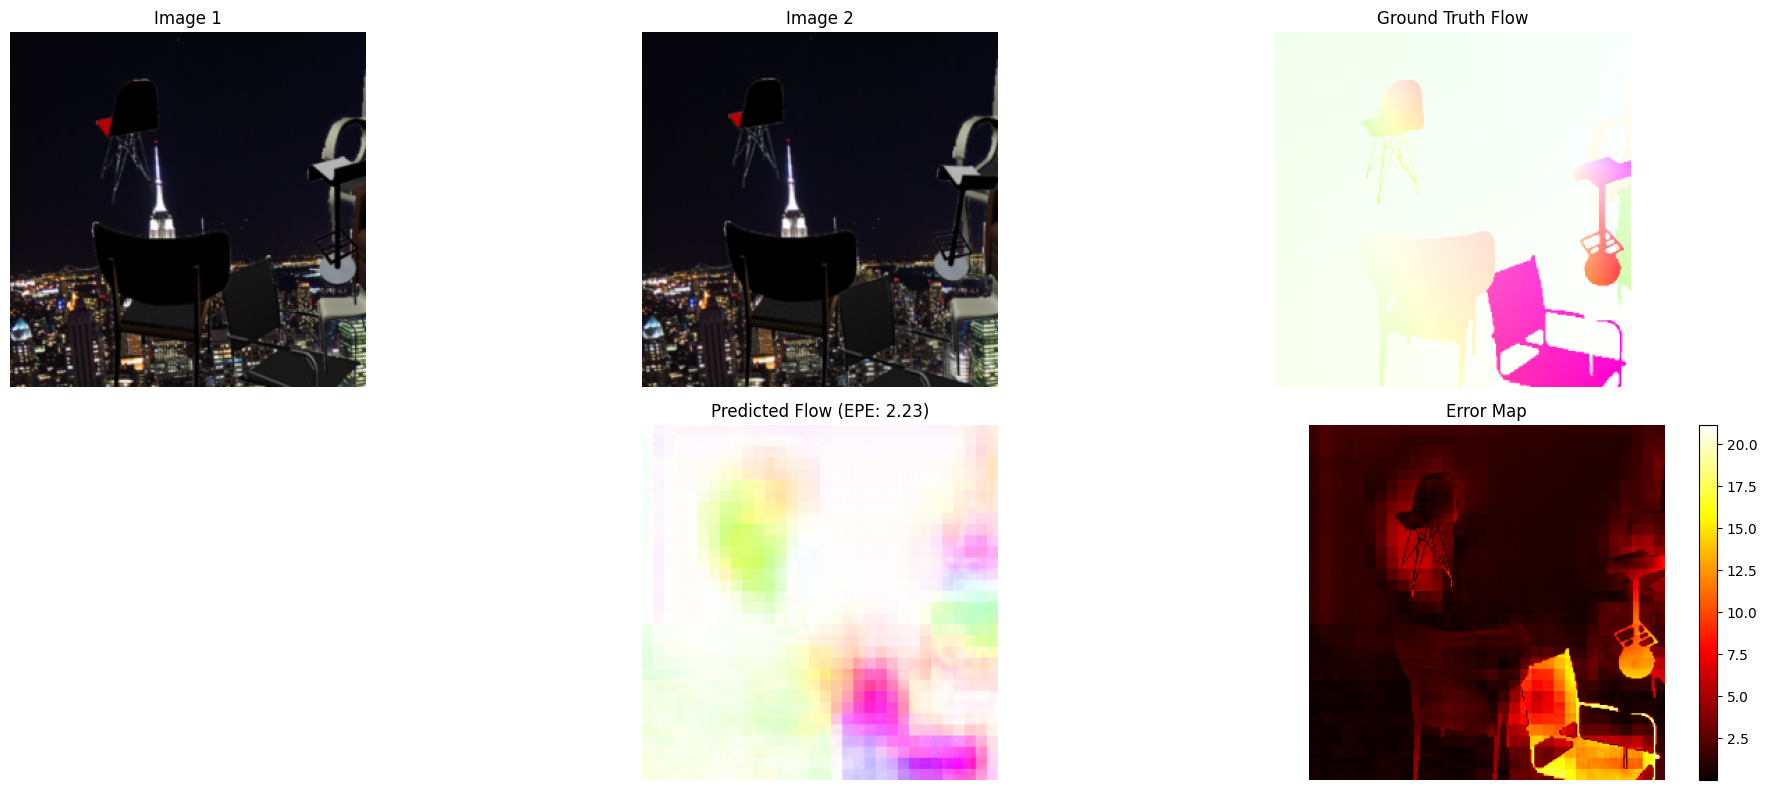

Average Endpoint Error: 2.2251 pixels


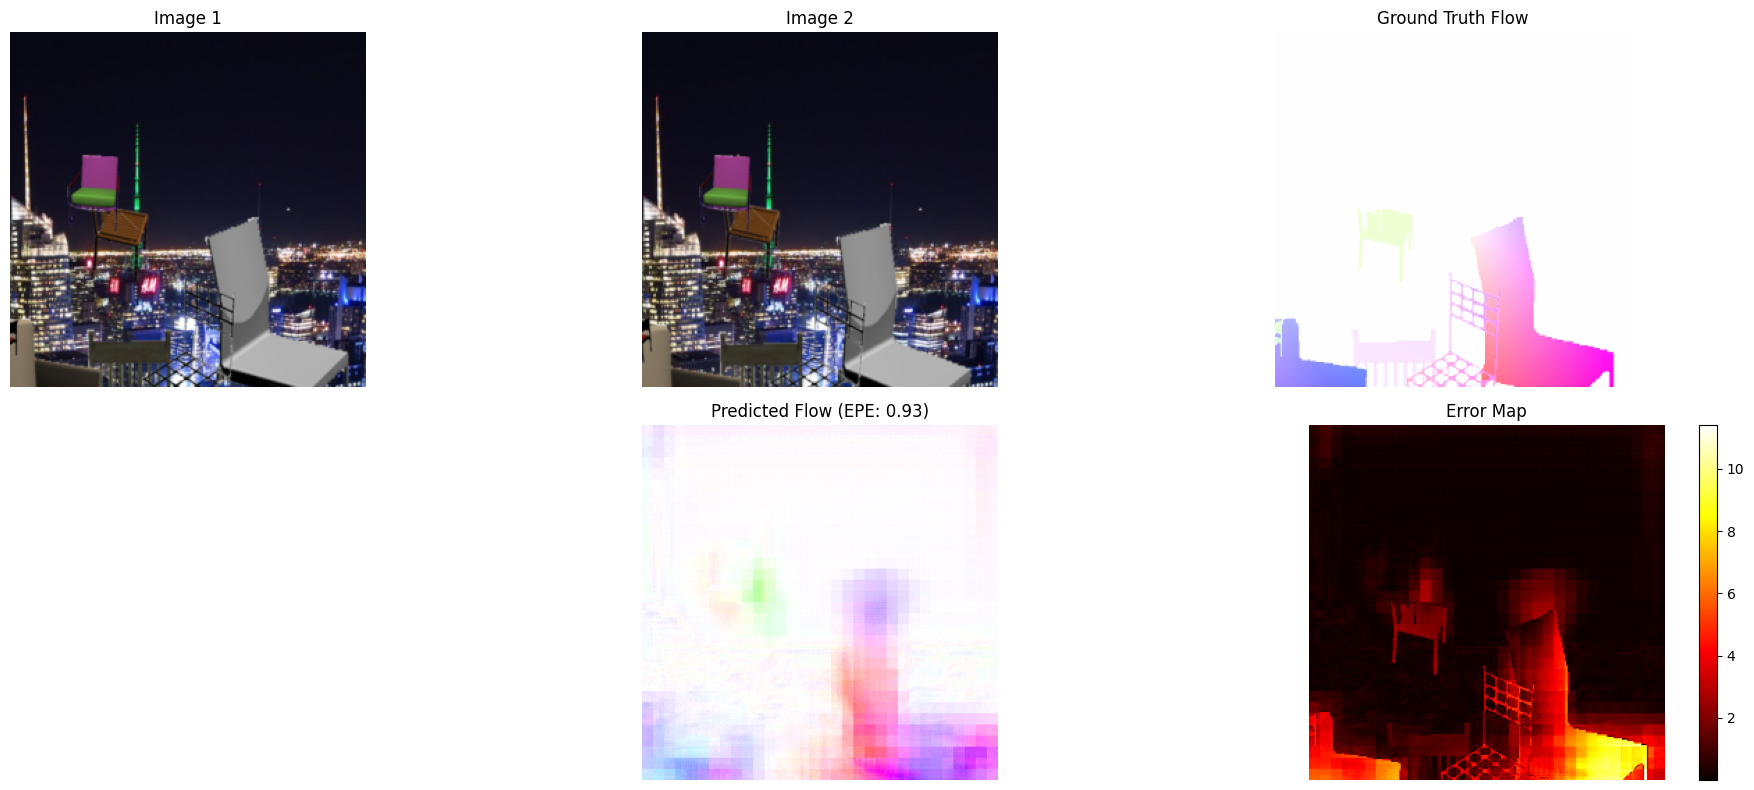

Average Endpoint Error: 0.9326 pixels


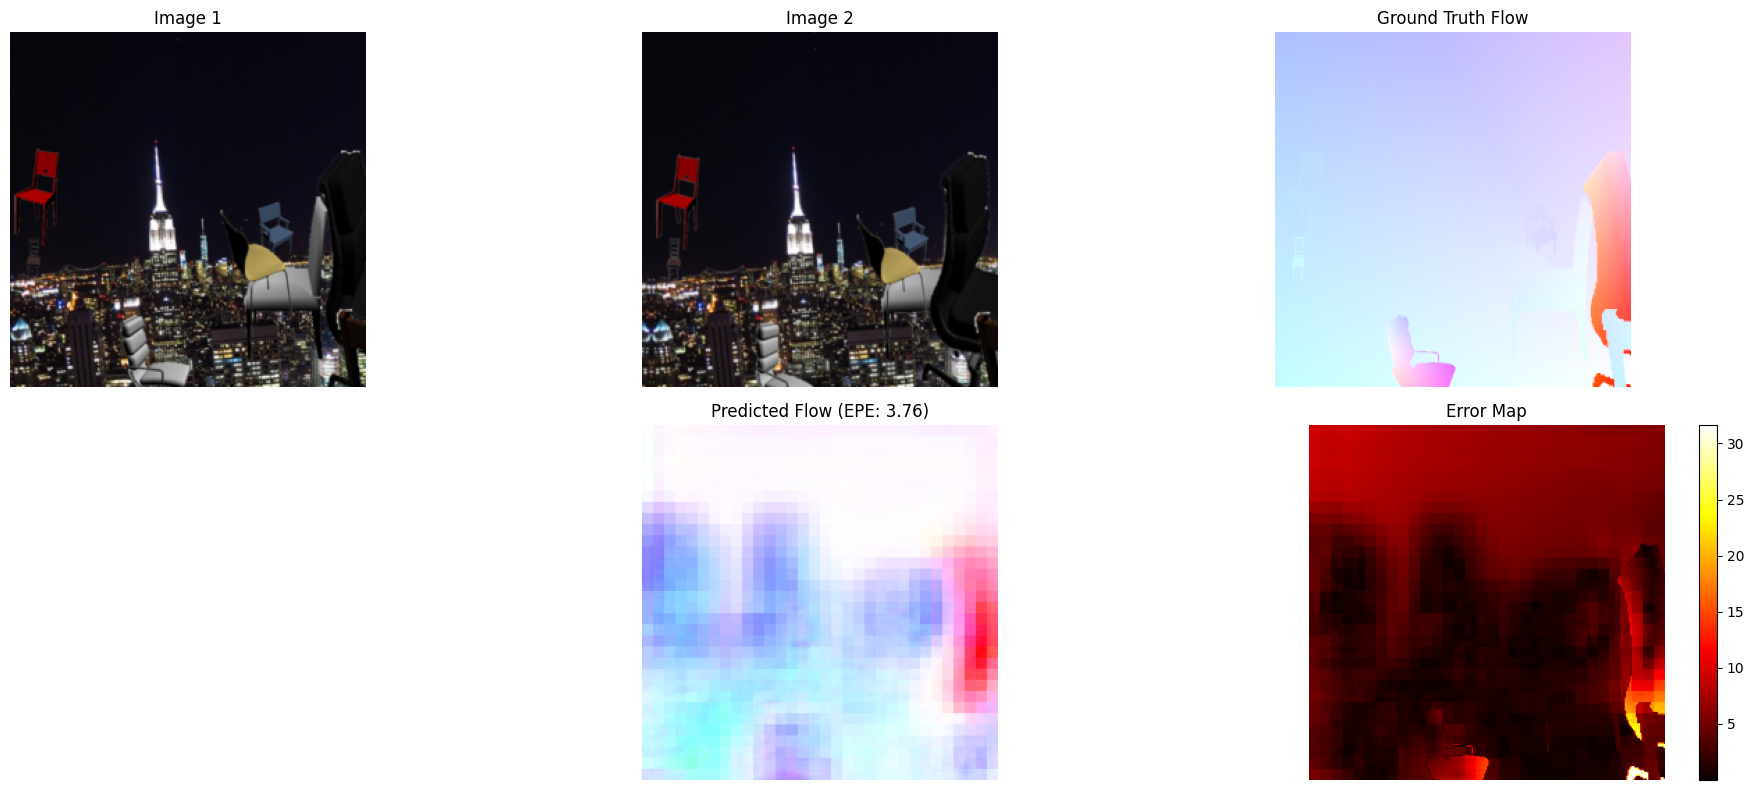

Average Endpoint Error: 3.7563 pixels


np.float32(3.756271)

In [9]:
import matplotlib.pyplot as plt
import torch
from Model import FlowNetSimple
from pathlib import Path
import random

root = r"E:\datasets\FlyingChairs_release"
checkpoint_dir = Path('./checkpoints')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="train")

# Cell: Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowNetSimple().to(device)

best_model_path = checkpoint_dir / 'best_flownet_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from iteration {checkpoint['iteration']}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Visualize predictions
visualize_flow_prediction(model, dataset, idx=0, device=device)
visualize_flow_prediction(model, dataset, idx=5, device=device)
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)